In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier


# Define a function to test the model (as required)
def testmymodel(model, X_features, y_labels):
    
    # Make predictions
    y_pred = model.predict(X_features)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_labels, y_pred) * 100
    
    return accuracy

# Class for custom One-vs-All Logistic Regression
class CustomOneVsAllLogisticRegression:
    def __init__(self, C=1.0, max_iter=100):
        
        self.C = C
        self.max_iter = max_iter
        self.models = []
        self.classes_ = None
        self.training_time = None
        self.prob_scores = None
    
    def fit(self, X, y):
        
        start_time = time.time()
        
        # Get unique classes
        self.classes_ = np.unique(y)
        
        # Train a binary classifier for each class
        for class_label in self.classes_:
            # Create binary target: 1 for current class, 0 for others
            binary_y = np.where(y == class_label, 1, 0)
            
            # Create and train the classifier
            model = LogisticRegression(C=self.C, max_iter=self.max_iter, solver='lbfgs')
            model.fit(X, binary_y)
            
            # Store the trained model
            self.models.append(model)
        
        self.training_time = time.time() - start_time
        return self
    
    def predict_proba(self, X):
        
        # Get probabilities from each binary classifier
        all_probs = np.zeros((X.shape[0], len(self.classes_)))
        
        for i, model in enumerate(self.models):
            # Get probability of positive class (class 1)
            probs = model.predict_proba(X)[:, 1]
            all_probs[:, i] = probs
        
        # Store probability scores for later use in computing log loss
        self.prob_scores = all_probs
            
        # Normalize probabilities to sum to 1
        row_sums = all_probs.sum(axis=1)
        normalized_probs = all_probs / row_sums[:, np.newaxis]
        
        return normalized_probs
    
    def predict(self, X):
        
        # Get probabilities
        probs = self.predict_proba(X)
        
        # Return class with highest probability
        return self.classes_[np.argmax(probs, axis=1)]
    
    def compute_log_loss(self, X, y):
        
        # Predict probabilities
        y_prob = self.predict_proba(X)
        
        # Convert y to one-hot encoding
        y_one_hot = np.zeros((len(y), len(self.classes_)))
        for i, class_idx in enumerate(self.classes_):
            y_one_hot[:, i] = (y == class_idx)
            
        # Compute log loss
        epsilon = 1e-15  # Small value to avoid log(0)
        y_prob = np.clip(y_prob, epsilon, 1 - epsilon)
        loss = -np.sum(y_one_hot * np.log(y_prob)) / len(y)
        
        return loss

In [5]:
# Load the CIFAR-10 dataset
# Replace these paths with the actual paths to your data files
X = np.load('cifar10_features.npy')  # Features file
Y = np.load('cifar10_labels.npy')  # Labels file

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training Softmax Logistic Regression...
Training One-vs-All Logistic Regression...

1. Comparing accuracy and run times:
Softmax accuracy: 96.27%, Training time: 0.18 seconds
Custom OvA accuracy: 96.19%, Training time: 0.30 seconds
Sklearn OvA accuracy: 96.19%, Training time: 0.32 seconds

2. Calculating cost functions:
Softmax log loss: 0.1091
Custom OvA log loss: 0.1443

3. Calculating F1-mean scores:
Softmax F1-mean: 0.9630
Custom OvA F1-mean: 0.9621
Sklearn OvA F1-mean: 0.9621

4. Analyzing confusion matrix for OvA:


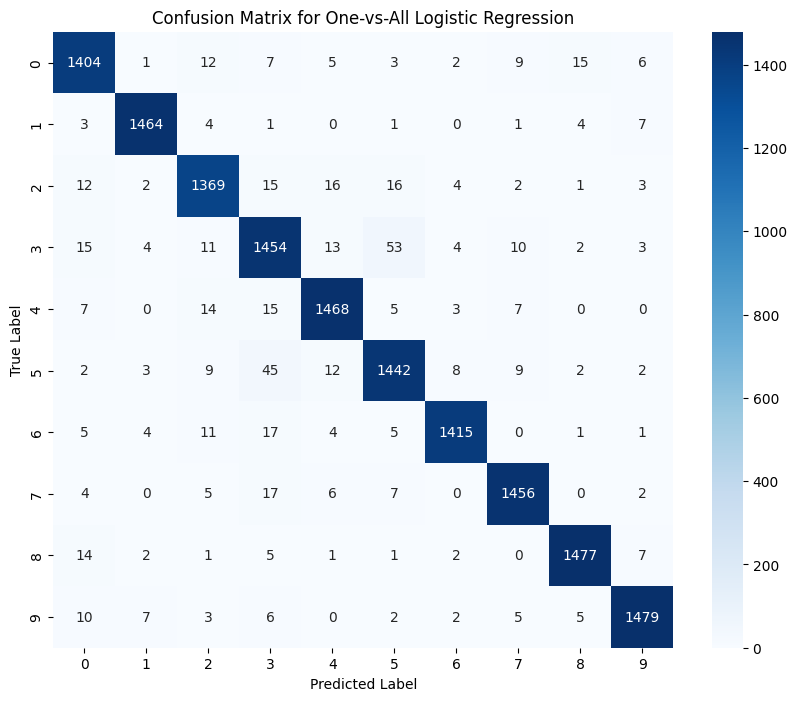

Comfused pairs array: [(0, 1, np.float64(4.0)), (0, 2, np.float64(24.0)), (0, 3, np.float64(22.0)), (0, 4, np.float64(12.0)), (0, 5, np.float64(5.0)), (0, 6, np.float64(7.0)), (0, 7, np.float64(13.0)), (0, 8, np.float64(29.0)), (0, 9, np.float64(16.0)), (1, 2, np.float64(6.0)), (1, 3, np.float64(5.0)), (1, 4, np.float64(0.0)), (1, 5, np.float64(4.0)), (1, 6, np.float64(4.0)), (1, 7, np.float64(1.0)), (1, 8, np.float64(6.0)), (1, 9, np.float64(14.0)), (2, 3, np.float64(26.0)), (2, 4, np.float64(30.0)), (2, 5, np.float64(25.0)), (2, 6, np.float64(15.0)), (2, 7, np.float64(7.0)), (2, 8, np.float64(2.0)), (2, 9, np.float64(6.0)), (3, 4, np.float64(28.0)), (3, 5, np.float64(98.0)), (3, 6, np.float64(21.0)), (3, 7, np.float64(27.0)), (3, 8, np.float64(7.0)), (3, 9, np.float64(9.0)), (4, 5, np.float64(17.0)), (4, 6, np.float64(7.0)), (4, 7, np.float64(13.0)), (4, 8, np.float64(1.0)), (4, 9, np.float64(0.0)), (5, 6, np.float64(13.0)), (5, 7, np.float64(16.0)), (5, 8, np.float64(3.0)), (5, 9, n

In [6]:

# Train and evaluate the Softmax Logistic Regression
print("Training Softmax Logistic Regression...")
start_time = time.time()
softmax_model = LogisticRegression(solver='lbfgs', C=1.0, max_iter=1000)
# softmax_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=1.0, max_iter=1000)
softmax_model.fit(X_train_scaled, y_train)
softmax_training_time = time.time() - start_time

# Train and evaluate the One-vs-All Logistic Regression
print("Training One-vs-All Logistic Regression...")
ova_model = CustomOneVsAllLogisticRegression(C=1.0, max_iter=1000)
ova_model.fit(X_train_scaled, y_train)

# Train and evaluate scikit-learn's One-vs-Rest for comparison
sklearn_ova_model = OneVsRestClassifier(LogisticRegression(C=1.0, max_iter=1000))
start_time = time.time()
sklearn_ova_model.fit(X_train_scaled, y_train)
sklearn_ova_training_time = time.time() - start_time

# 1. Compare accuracy and run times
print("\n1. Comparing accuracy and run times:")
print(f"Softmax accuracy: {testmymodel(softmax_model, X_test_scaled, y_test):.2f}%, Training time: {softmax_training_time:.2f} seconds")
print(f"Custom OvA accuracy: {testmymodel(ova_model, X_test_scaled, y_test):.2f}%, Training time: {ova_model.training_time:.2f} seconds")
print(f"Sklearn OvA accuracy: {testmymodel(sklearn_ova_model, X_test_scaled, y_test):.2f}%, Training time: {sklearn_ova_training_time:.2f} seconds")

# 2. Calculate the cost function (log loss)
print("\n2. Calculating cost functions:")
# For Softmax model
softmax_probs = softmax_model.predict_proba(X_test_scaled)
softmax_loss = log_loss(y_test, softmax_probs)
print(f"Softmax log loss: {softmax_loss:.4f}")

# For Custom OvA model
ova_loss = ova_model.compute_log_loss(X_test_scaled, y_test)
print(f"Custom OvA log loss: {ova_loss:.4f}")

# 3. Calculate F1-mean scores
print("\n3. Calculating F1-mean scores:")
# Predictions
softmax_preds = softmax_model.predict(X_test_scaled)
ova_preds = ova_model.predict(X_test_scaled)
sklearn_ova_preds = sklearn_ova_model.predict(X_test_scaled)

# F1 scores
softmax_f1 = f1_score(y_test, softmax_preds, average='macro')
ova_f1 = f1_score(y_test, ova_preds, average='macro')
sklearn_ova_f1 = f1_score(y_test, sklearn_ova_preds, average='macro')

print(f"Softmax F1-mean: {softmax_f1:.4f}")
print(f"Custom OvA F1-mean: {ova_f1:.4f}")
print(f"Sklearn OvA F1-mean: {sklearn_ova_f1:.4f}")

# 4. Confusion matrix analysis for OvA
print("\n4. Analyzing confusion matrix for OvA:")
cm = confusion_matrix(y_test, ova_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for One-vs-All Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Find the most confused class pairs
class_error_rates = np.zeros((len(ova_model.classes_), len(ova_model.classes_)))

for i in range(len(ova_model.classes_)):
    for j in range(len(ova_model.classes_)):
        if i != j:
            # Count how many times class i was predicted as class j
            class_error_rates[i, j] = cm[i, j]

# Get the top confused pairs
confused_pairs = []
for i in range(len(ova_model.classes_)):
    for j in range(i+1, len(ova_model.classes_)):
        total_confusion = class_error_rates[i, j] + class_error_rates[j, i]
        confused_pairs.append((i, j, total_confusion))

print("Comfused pairs array:", confused_pairs)

# Sort pairs by confusion amount
confused_pairs.sort(key=lambda x: x[2], reverse=True)

print("Top confused class pairs:")
for i, j, confusion in confused_pairs[:3]:
    print(f"Classes {i} and {j}: {confusion} mutual misclassifications")

# 5. Creating a specialized model for the most confused class pair
most_confused_pair = confused_pairs[0][:2]
class_a, class_b = most_confused_pair

print(f"\n5. Creating specialized model for classes {class_a} and {class_b}:")

# Extract samples from these two classes only
mask_train = np.logical_or(y_train == class_a, y_train == class_b)
X_pair_train = X_train_scaled[mask_train]
y_pair_train = y_train[mask_train]
# Convert to binary classification problem
y_pair_train_binary = np.where(y_pair_train == class_a, 0, 1)

mask_test = np.logical_or(y_test == class_a, y_test == class_b)
X_pair_test = X_test_scaled[mask_test]
y_pair_test = y_test[mask_test]
y_pair_test_binary = np.where(y_pair_test == class_a, 0, 1)

# Train specialized model
specialized_model = LogisticRegression(C=1.0, max_iter=1000)
specialized_model.fit(X_pair_train, y_pair_train_binary)

# Evaluate specialized model
specialized_preds_binary = specialized_model.predict(X_pair_test)
specialized_preds = np.where(specialized_preds_binary == 0, class_a, class_b)
specialized_accuracy = accuracy_score(y_pair_test, specialized_preds) * 100

print(f"Original OvA accuracy on these two classes: {accuracy_score(y_pair_test, ova_preds[mask_test]) * 100:.2f}%")
print(f"Specialized model accuracy: {specialized_accuracy:.2f}%")


# Create hybrid model using OvA for initial classification and specialized model for confused classes
class HybridModel:
    def __init__(self, base_model, specialized_model, class_a, class_b):
        self.base_model = base_model
        self.specialized_model = specialized_model
        self.class_a = class_a
        self.class_b = class_b
        
    def predict(self, X):
        # Get predictions from base model
        base_preds = self.base_model.predict(X)
        
        # For samples predicted as either class_a or class_b, use the specialized model
        mask = np.logical_or(base_preds == self.class_a, base_preds == self.class_b)
        if np.any(mask):
            specialized_preds_binary = self.specialized_model.predict(X[mask])
            specialized_preds = np.where(specialized_preds_binary == 0, self.class_a, self.class_b)
            base_preds[mask] = specialized_preds
            
        return base_preds

# Create and evaluate hybrid model
hybrid_model = HybridModel(ova_model, specialized_model, class_a, class_b)
hybrid_accuracy = testmymodel(hybrid_model, X_test_scaled, y_test)

print(f"Original OvA overall accuracy: {testmymodel(ova_model, X_test_scaled, y_test):.2f}%")
print(f"Hybrid model overall accuracy: {hybrid_accuracy:.2f}%")

# Summary of findings
print("\nSummary of Findings:")
print(f"1. Softmax Accuracy: {testmymodel(softmax_model, X_test_scaled, y_test):.2f}%, F1: {softmax_f1:.4f}, Log Loss: {softmax_loss:.4f}")
print(f"2. Custom OvA Accuracy: {testmymodel(ova_model, X_test_scaled, y_test):.2f}%, F1: {ova_f1:.4f}, Log Loss: {ova_loss:.4f}")
print(f"3. Most confused classes: {class_a} and {class_b}")
print(f"4. Specialized model improved classification between these classes by: {specialized_accuracy - accuracy_score(y_pair_test, ova_preds[mask_test]) * 100:.2f}%")
print(f"5. Overall accuracy improvement with hybrid model: {hybrid_accuracy - testmymodel(ova_model, X_test_scaled, y_test):.2f}%")

